# Spotify dataset analysis

O Spotify possui uma Web API e essa API possui uma tradução para Python chamada Spotipy. Ela permite buscar informações de músicas, playlists artistas. Dentre as informações disponíveis, existem as chamadas *audio features*, que são métricas musicais do tipo `danceability`, `loudness` e `instrumentalness`, que podem ser importantes para modelos de recomendação.

Os dados foram capturados utilizando a API. A abordagem foi a seguinte:
1. Iniciamos com um conjunto grande de usuários do Last.fm, que permite a busca em rede (usuários e seus seguidores);
2. Selecionamos um subconjunto de 1000 desses usuários que também possuem conta no Spotify;
3. Selecionamos suas playlists públicas;
4. Selecionamos as músicas dessas playlists;
5. We selected the audio features and the artists from these tracks.

It's important to note that songs don't have genres using this API. Who has genre is the artist of the track. So it's necessary to gather the artists of the tracks.

At the end, we have:
- Users **tracks** dataset;
- List of **users**;
- **Playlists** of the tracks;
- **Audio features** of the tracks;
- **Artists** of the tracks.

We now make some exploration in order to get known the data and have insights for the recommendation models.

In [1]:
from collections import Counter
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Necessary to improve exploration
pd.set_option('display.max_columns', None)

# Beautiful Seaborn
sns.set()

## Initial exploration: datasets

We have many datasets, and we wanna know its variables. Let's sample them.

### Tracks dataset

In [3]:
tracks = pd.read_pickle('../data/sp_tracks_ready_999.pkl')
tracks.sample()

,added_at,added_by,is_local,playlist_id,available_markets,disc_number,duration_ms,explicit,id,name,popularity,track_number,album_type,album_available_markets,album_id,album_name,album_release_date,artists_ids,artists_names,album_artists_ids,album_artists_names
46947,2014-05-16 17:39:52+00:00,marcosmoretto,True,1xEuCRMLwr6cvjTgBiTnca,[],0.0,209000.0,False,None,Say It Again,0.0,0.0,None,[],None,Pocketful Of Sunshine,None,NaN,[Natasha Bedingfield],NaN,NaN


**Tracks** dataset is big enough to make we split it in many files. So we did it. At now we have 11 files just for the tracks. But the other datasets are compressed in a single file each one.

In [5]:
list(tracks.columns)

['added_at',
 'added_by',
 'is_local',
 'playlist_id',
 'available_markets',
 'disc_number',
 'duration_ms',
 'explicit',
 'id',
 'name',
 'popularity',
 'track_number',
 'album_type',
 'album_available_markets',
 'album_id',
 'album_name',
 'album_release_date',
 'artists_ids',
 'artists_names',
 'album_artists_ids',
 'album_artists_names']

It's important to note that everything on Spotify have an ID. So when we have a song and know the ID of one playlist that contains it, we can use this playlist ID to search for the playlist data.

In the dataset, we see that a track have many features, which can be viewed as:
- **Playlist** features: information about the playlists, like when the song was added, who added it and the ID of the playlist.
- **Track** features: like `disc_number`, its duration, if its explicit, `id`, its name, popularity and its number.
- **Album** features, including artists of the album;
- **Artists** features: their IDs and names.

Many features have lists as values. It's because some of them have values which vary in length, like the `artists_ids`. We don't know if we will have 1, 2 or 32 artists. It will happen with other datasets too.

### Playlists dataset

In [4]:
playlists = pd.read_pickle('../data/sp_playlists.pkl')

In [7]:
playlists.sample()

,collaborative,description,id,name,primary_color,public,tracks,owner_id
3992,False,,3UuOn6KoHubwMvYuiPKx7E,Koh Lantana – Silent Moments,None,True,{'href': 'https://api.spotify.com/v1/playlists...,realjaco


Here we have basic information about a public playlist. One thing to note is that everything Spotipy returns is a JSON file, in the 'records' format. So in the column `tracks` we have a dict containing information about the tracks.

In [8]:
playlists.loc[0, 'tracks']

{'href': 'https://api.spotify.com/v1/playlists/0itjZK4e1qZzHL9fNInUJR/tracks',
 'total': 63}

It's little information, but it's not important. The tracks was gathered from the playlist using the ID of the playlist.

### Audio features dataset

Maybe only track information is not enough to make good recommendation systems. So we gather more information, this time more technician:

In [5]:
audio_features = pd.read_pickle('../data/sp_audio_features.pkl')

In [10]:
audio_features.sample()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
452117,0.462,0.727,7,-4.298,1,0.0383,0.212,0.0,0.192,0.475,138.806,45I1Wx82w8ArHSpV7dBp09,227440,3


Here we have the ID of the track and its features, like ` liveness` and `speechiness`. More information about this technical parte can be found on the [documentation of the Web API](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

Another thing to note is that some of `duration_ms` differs from the ones in the tracks database. Let's see:

In [19]:
my_id = None
while pd.isnull(my_id):
    my_id = tracks.sample().id.iloc[0] 

In [20]:
print(
    tracks[tracks.id == my_id].duration_ms.iloc[0],
    audio_features[audio_features.id == my_id].duration_ms.iloc[0]
)

256546.0 256547


### Artists dataset

In [6]:
artists = pd.read_pickle('../data/sp_artists.pkl')

In [23]:
artists.sample()

,followers,genres,id,name,popularity
65337,37284,"[alternative pop, alternative rock]",5LEUigTSXpwrtERRcSW1N4,Urge Overkill,51


Artists datasets are simple and autoexplanative. It's important to note `genres` features, because each cell is a list of genres. As already said, the only way to classify a song in a genre is with the genres of its artists.

## Exploration

Now he have the intuition and the knowlegde to explore the data.

### Tracks

#### Missing values and data types

Let's do the homework. The missing values:

In [24]:
tracks.dtypes

added_at                   datetime64[ns, UTC]
added_by                                object
is_local                                  bool
playlist_id                             object
available_markets                       object
disc_number                            float64
duration_ms                            float64
explicit                                object
id                                      object
name                                    object
popularity                             float64
track_number                           float64
album_type                              object
album_available_markets                 object
album_id                                object
album_name                              object
album_release_date                      object
artists_ids                             object
artists_names                           object
album_artists_ids                       object
album_artists_names                     object
dtype: object

dtypes seems to be OK, with exception of `explicit` (should be a bool) and `album_release_date` (should be a date). But they are extremely easy to deal with.

In [47]:
sum([pd.read_pickle(file).isnull().sum() for file in glob.glob('../data/sp_tracks_ready_*.pkl')])

added_at                       0
added_by                       0
is_local                       0
playlist_id                    0
available_markets            240
disc_number                  240
duration_ms                  240
explicit                     240
id                         39115
name                         240
popularity                   240
track_number                 240
album_type                 39115
album_available_markets      240
album_id                   39115
album_name                   240
album_release_date         39115
artists_ids                39115
artists_names                240
album_artists_ids          39115
album_artists_names        39115
dtype: int64

He have many missing values, in some specific tracks (the numbers coincide). Let's look into one of them:

In [25]:
# One of the 39115
tracks[pd.isnull(tracks.id)].sample()

,added_at,added_by,is_local,playlist_id,available_markets,disc_number,duration_ms,explicit,id,name,popularity,track_number,album_type,album_available_markets,album_id,album_name,album_release_date,artists_ids,artists_names,album_artists_ids,album_artists_names
60258,2016-05-14 18:44:15+00:00,marcosmoretto,True,00RyLvaDIOBJo2yfEq2Ewr,[],0.0,204000.0,False,None,Timber (feat. Ke$ha),0.0,0.0,None,[],None,Timber (feat. Ke$ha) - Single,None,NaN,[Pitbull],NaN,NaN


In [26]:
# One of the 240
tracks[pd.isnull(tracks.duration_ms)].sample()

,added_at,added_by,is_local,playlist_id,available_markets,disc_number,duration_ms,explicit,id,name,popularity,track_number,album_type,album_available_markets,album_id,album_name,album_release_date,artists_ids,artists_names,album_artists_ids,album_artists_names
51042,2020-07-31 17:18:56+00:00,katrin1994,False,7yh6OSV88noq3xosMtml7e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Number of tracks (it's huge)
sum([len(pd.read_pickle(file)) for file in glob.glob('../data/sp_tracks_ready_*.pkl')])

849397

In [28]:
print('Approx. {:.3f}% of the data has missing values.'.format((39115)/849397*100))

Approx. 4.605% of the data has missing values.


It's seems not to be a problem to drop these rows, because of the dropped data will be just a little. One problem is that it will affect the other datasets.

#### Features distribution

We will look into the distribution of the data, like the dates, the number and the categories. We will check for duplicity and will make a `describe`.

A track is dupplicated when it's the same track in the same playlist and was added at the same time.

In [34]:
duplicated = 0
for file in glob.glob('../data/sp_tracks_ready_*.pkl'):
    df = pd.read_pickle(file)
    duplicated += len(df[(df.id + df.playlist_id + df.added_at.apply(str)).duplicated()])
print(duplicated)

43781


We have many duplicated values. But the IDs where unified when dealling with audio features and artists.

We also found a playlist with the same song added 2048 times, with 1024 of them added at the same time!

In [35]:
tracks[(tracks.id == '3vllUzZChqpEaAat9brOYV') & (tracks.playlist_id == '3MPa29N5KpS3ZOk2B4PlUq') & (tracks.added_at == '2018-01-01 09:27:46+00:00')]

,added_at,added_by,is_local,playlist_id,available_markets,disc_number,duration_ms,explicit,id,name,popularity,track_number,album_type,album_available_markets,album_id,album_name,album_release_date,artists_ids,artists_names,album_artists_ids,album_artists_names
17191,2018-01-01 09:27:46+00:00,stabbedmeat,False,3MPa29N5KpS3ZOk2B4PlUq,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1.0,205760.0,True,3vllUzZChqpEaAat9brOYV,FACK,41.0,2.0,compilation,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1zUY4PAFrNUOCeaEBrEHzh,Curtain Call: The Hits,2005-12-06,[7dGJo4pcD2V6oG8kP0tJRR],[Eminem],[7dGJo4pcD2V6oG8kP0tJRR],[Eminem]
17192,2018-01-01 09:27:46+00:00,stabbedmeat,False,3MPa29N5KpS3ZOk2B4PlUq,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1.0,205760.0,True,3vllUzZChqpEaAat9brOYV,FACK,41.0,2.0,compilation,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1zUY4PAFrNUOCeaEBrEHzh,Curtain Call: The Hits,2005-12-06,[7dGJo4pcD2V6oG8kP0tJRR],[Eminem],[7dGJo4pcD2V6oG8kP0tJRR],[Eminem]
17193,2018-01-01 09:27:46+00:00,stabbedmeat,False,3MPa29N5KpS3ZOk2B4PlUq,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1.0,205760.0,True,3vllUzZChqpEaAat9brOYV,FACK,41.0,2.0,compilation,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1zUY4PAFrNUOCeaEBrEHzh,Curtain Call: The Hits,2005-12-06,[7dGJo4pcD2V6oG8kP0tJRR],[Eminem],[7dGJo4pcD2V6oG8kP0tJRR],[Eminem]
17194,2018-01-01 09:27:46+00:00,stabbedmeat,False,3MPa29N5KpS3ZOk2B4PlUq,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1.0,205760.0,True,3vllUzZChqpEaAat9brOYV,FACK,41.0,2.0,compilation,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1zUY4PAFrNUOCeaEBrEHzh,Curtain Call: The Hits,2005-12-06,[7dGJo4pcD2V6oG8kP0tJRR],[Eminem],[7dGJo4pcD2V6oG8kP0tJRR],[Eminem]
17195,2018-01-01 09:27:46+00:00,stabbedmeat,False,3MPa29N5KpS3ZOk2B4PlUq,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1.0,205760.0,True,3vllUzZChqpEaAat9brOYV,FACK,41.0,2.0,compilation,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1zUY4PAFrNUOCeaEBrEHzh,Curtain Call: The Hits,2005-12-06,[7dGJo4pcD2V6oG8kP0tJRR],[Eminem],[7dGJo4pcD2V6oG8kP0tJRR],[Eminem]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18210,2018-01-01 09:27:46+00:00,stabbedmeat,False,3MPa29N5KpS3ZOk2B4PlUq,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1.0,205760.0,True,3vllUzZChqpEaAat9brOYV,FACK,41.0,2.0,compilation,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1zUY4PAFrNUOCeaEBrEHzh,Curtain Call: The Hits,2005-12-06,[7dGJo4pcD2V6oG8kP0tJRR],[Eminem],[7dGJo4pcD2V6oG8kP0tJRR],[Eminem]
18211,2018-01-01 09:27:46+00:00,stabbedmeat,False,3MPa29N5KpS3ZOk2B4PlUq,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1.0,205760.0,True,3vllUzZChqpEaAat9brOYV,FACK,41.0,2.0,compilation,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1zUY4PAFrNUOCeaEBrEHzh,Curtain Call: The Hits,2005-12-06,[7dGJo4pcD2V6oG8kP0tJRR],[Eminem],[7dGJo4pcD2V6oG8kP0tJRR],[Eminem]
18212,2018-01-01 09:27:46+00:00,stabbedmeat,False,3MPa29N5KpS3ZOk2B4PlUq,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1.0,205760.0,True,3vllUzZChqpEaAat9brOYV,FACK,41.0,2.0,compilation,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1zUY4PAFrNUOCeaEBrEHzh,Curtain Call: The Hits,2005-12-06,[7dGJo4pcD2V6oG8kP0tJRR],[Eminem],[7dGJo4pcD2V6oG8kP0tJRR],[Eminem]
18213,2018-01-01 09:27:46+00:00,stabbedmeat,False,3MPa29N5KpS3ZOk2B4PlUq,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1.0,205760.0,True,3vllUzZChqpEaAat9brOYV,FACK,41.0,2.0,compilation,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1zUY4PAFrNUOCeaEBrEHzh,Curtain Call: The Hits,2005-12-06,[7dGJo4pcD2V6oG8kP0tJRR],[Eminem],[7dGJo4pcD2V6oG8kP0tJRR],[Eminem]


Let's make a `describe`.

In [36]:
tracks.describe()

,disc_number,duration_ms,popularity,track_number
count,62628.000000,6.262800e+04,62628.000000,62628.000000
mean,1.000782,2.345405e+05,27.463116,5.116769
std,0.474441,9.027254e+04,26.100438,6.330573
min,0.000000,0.000000e+00,0.000000,0.000000
25%,1.000000,1.919060e+05,0.000000,1.000000
50%,1.000000,2.202930e+05,25.000000,3.000000
75%,1.000000,2.618800e+05,49.000000,7.000000
max,43.000000,4.681906e+06,100.000000,159.000000


There are tracks with duration 0:

In [37]:
tracks[tracks.duration_ms == 0]

,added_at,added_by,is_local,playlist_id,available_markets,disc_number,duration_ms,explicit,id,name,popularity,track_number,album_type,album_available_markets,album_id,album_name,album_release_date,artists_ids,artists_names,album_artists_ids,album_artists_names
39096,2010-12-08 20:23:57+00:00,,False,6KDJ5FumLzap9zJ2Ekaaxf,[],1.0,0.0,False,2h0PVoVGyPLYONgXDs6V6i,Too Late For Goodbye,0.0,3.0,album,[],4p6822xC4ni8qkEbLsHCjK,Burning The Day,2010-01-01,[04DUpHOyQqwbHFyvIhcGi3],[Randy Rogers Band],[04DUpHOyQqwbHFyvIhcGi3],[Randy Rogers Band]


In fact the song has 3min40s.

We also found some tracks which were added in 1970! It's obviously not true.

In [38]:
tracks.added_at.min()

Timestamp('1970-01-01 00:00:00+0000', tz='UTC')

In [39]:
tracks.added_at.max()

Timestamp('2020-08-04 03:59:31+0000', tz='UTC')

### Playlists

#### Missing values and data types

In [40]:
playlists.dtypes

collaborative      bool
description      object
id               object
name             object
primary_color    object
public             bool
tracks           object
owner_id         object
dtype: object

It seems OK.

In [41]:
playlists.isnull().sum()

collaborative        0
description          0
id                   0
name                 0
primary_color    11617
public               0
tracks               0
owner_id             0
dtype: int64

In [42]:
len(playlists)

11617

There are no `primary_colors`.

#### Features distribution

A track is dupplicated when it's the same track in the same playlist and was added at the same time.

In [45]:
playlists.duplicated('id').sum()

690

He have a lot of repeated playlists, but it was treated when dealing with the tracks!

### Audio features

#### Missing values and data types

In [49]:
audio_features.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
id                   object
duration_ms           int64
time_signature        int64
dtype: object

It seems OK.

In [50]:
audio_features.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
id                  0
duration_ms         0
time_signature      0
dtype: int64

Nice!

#### Features distribution

In [52]:
audio_features.duplicated('id').sum()

0

Nice too!

In [54]:
audio_features.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,491595.000000,491595.000000,491595.000000,491595.000000,491595.000000,491595.000000,491595.000000,491595.000000,491595.000000,491595.000000,491595.000000,4.915950e+05,491595.000000
mean,0.555357,0.636276,5.281917,-8.746491,0.623934,0.096430,0.273871,0.202287,0.204890,0.470628,121.422468,2.426466e+05,3.905933
std,0.176397,0.248168,3.578772,4.880195,0.484397,0.143514,0.318675,0.331959,0.179179,0.257163,29.159548,1.205123e+05,0.435442
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.347000e+03,0.000000
25%,0.438000,0.466000,2.000000,-10.730000,0.000000,0.035500,0.010500,0.000001,0.096400,0.260000,99.875500,1.869330e+05,4.000000
50%,0.569000,0.679000,5.000000,-7.551000,1.000000,0.048300,0.116000,0.001000,0.129000,0.460000,121.030000,2.239600e+05,4.000000
75%,0.686000,0.843000,9.000000,-5.438000,1.000000,0.086100,0.494000,0.302000,0.263000,0.676000,138.700000,2.740400e+05,4.000000
max,0.993000,1.000000,11.000000,5.118000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,249.987000,5.925082e+06,5.000000


### Artists

#### Missing values and data types

In [55]:
artists.dtypes

followers      int64
genres        object
id            object
name          object
popularity     int64
dtype: object

In [56]:
artists.isnull().sum()

followers     0
genres        0
id            0
name          0
popularity    0
dtype: int64

It seems nice.

#### Features distribution

In [58]:
artists.duplicated('id').sum()

1

In [59]:
artists[artists.duplicated('id')]

,followers,genres,id,name,popularity
54492,46903,"[jazz funk, jazz fusion, jazz guitar]",3zX0EMvB00JzxnRi5EIICP,Mike Stern,36


In [60]:
artists[artists.id == '3zX0EMvB00JzxnRi5EIICP']

,followers,genres,id,name,popularity
1554,0,"[jazz funk, jazz fusion, jazz guitar]",3zX0EMvB00JzxnRi5EIICP,Mike Stern,36
54492,46903,"[jazz funk, jazz fusion, jazz guitar]",3zX0EMvB00JzxnRi5EIICP,Mike Stern,36


We have only one artist duplicated.

Let's make a `describe`.

In [61]:
artists.describe()

,followers,popularity
count,1.076220e+05,107622.000000
mean,7.451927e+04,28.218738
std,6.882583e+05,18.822269
min,0.000000e+00,0.000000
25%,1.950000e+02,12.000000
50%,1.628000e+03,28.000000
75%,1.212900e+04,42.000000
max,6.757670e+07,100.000000


The most followed artist:

In [63]:
artists[artists.followers == artists.followers.max()]

,followers,genres,id,name,popularity
84115,67576701,"[pop, uk pop]",6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,92


## Visualizations

We will try to anwer questions about the data using visualizations.

### When a track was added to a playlist?

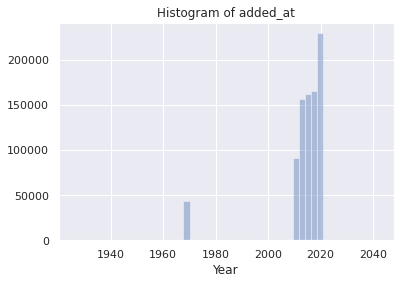

In [58]:
data = pd.concat(
    [pd.read_pickle(file)['added_at'] for file in glob.glob('../data/sp_tracks_ready_*.pkl')],
    ignore_index=True
)

sns.distplot(data.dt.year, kde=False)
plt.title("Histogram of added_at")
plt.xlabel("Year")
plt.show()

The max date is:

In [59]:
data.max()

Timestamp('2042-07-07 10:02:09+0000', tz='UTC')

We see some outliers, so we filter them:

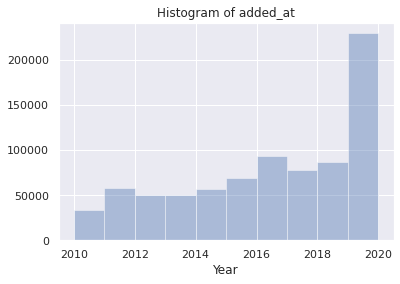

In [60]:
sns.distplot(data[(data > '2000') & (data < '2021')].dt.year, kde=False, bins=10)
plt.title("Histogram of added_at")
plt.xlabel("Year")
plt.show()

Most of the songs were added recently.

### How much time does a track take?

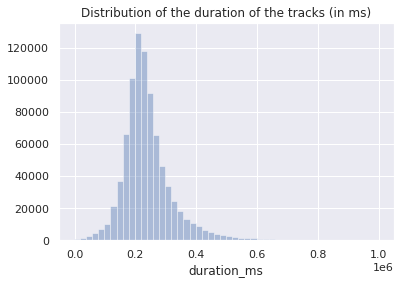

In [63]:
data = pd.concat(
    [pd.read_pickle(file)['duration_ms'] for file in glob.glob('../data/sp_tracks_ready_*.pkl')],
    ignore_index=True
)

sns.distplot(data[data < 1e6], kde=False)
plt.title("Distribution of the duration of the tracks (in ms)")
plt.show()

The mode of the songs has 3min20s.

## Are the songs popular?

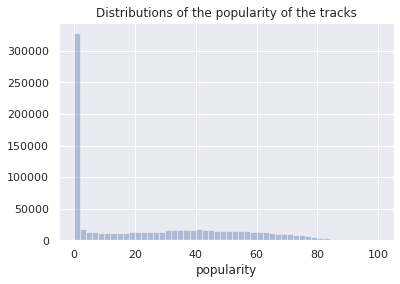

In [64]:
data = pd.concat(
    [pd.read_pickle(file)['popularity'] for file in glob.glob('../data/sp_tracks_ready_*.pkl')],
    ignore_index=True
)

sns.distplot(data, kde=False)
plt.title("Distributions of the popularity of the tracks")
plt.show()

We see that a lot of songs are not popular at all, maybe it's a missing value.

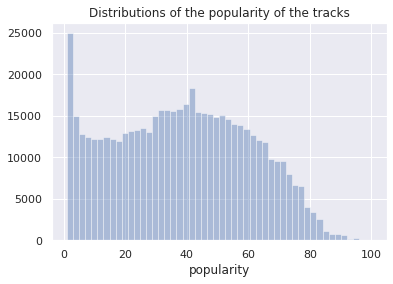

In [65]:
sns.distplot(data[data > 0], kde=False)
plt.title("Distributions of the popularity of the tracks")
plt.show()

Most of songs are not popular, but those who are popular have mode at approx. 42. A few tracks have big popularities. For example, the most popular track in our dataset:

In [67]:
tracks[tracks.popularity == tracks.popularity.max()].name.iloc[0]

'ROCKSTAR (feat. Roddy Ricch)'

In [68]:
tracks[tracks.popularity == tracks.popularity.max()].artists_names.iloc[0]

['DaBaby', 'Roddy Ricch']

In [69]:
artists[(artists.name == 'DaBaby') | (artists.name == 'Roddy Ricch')]

,followers,genres,id,name,popularity
59207,3884369,"[north carolina hip hop, rap]",4r63FhuTkUYltbVAg5TQnk,DaBaby,94
65851,3646033,"[melodic rap, rap]",757aE44tKEUQEqRuT6GnEB,Roddy Ricch,93


The artists of the track are very popular.

### How many playlists does a user have?

In [70]:
playlists.groupby('owner_id').count().id.sort_values(ascending=False)

owner_id
henkestrummer    849
spotify          809
littlestar19     704
chrispis         334
symboliccross    215
                ... 
kimmiebee          1
kieron             1
kidvector          1
kgstrat            1
!lu.               1
Name: id, Length: 1372, dtype: int64

Of course, Spotify is one of the biggest playlists owner. But it's not the first one in our dataset!

### How is the distribution of the number of tracks among playlists?

In [71]:
total = playlists.tracks.apply(lambda x: x['total'])

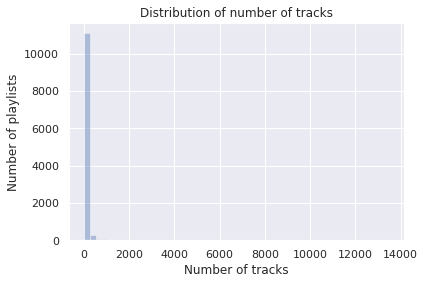

In [72]:
sns.distplot(total, kde=False)
plt.title("Distribution of number of tracks")
plt.xlabel("Number of tracks")
plt.ylabel("Number of playlists")
plt.show()

There are playlists with many many tracks. This one have more than 13 thousand!

In [77]:
playlists[total > 12000]

,collaborative,description,id,name,primary_color,public,tracks,owner_id
1398,False,,2ksOblphviHyEj35xjvnm2,New Playlist,None,True,{'href': 'https://api.spotify.com/v1/playlists...,bendelvio


In [78]:
playlists[total > 12000].iloc[0, 6]['total']

13459

Without these outliers, what's the distribution?

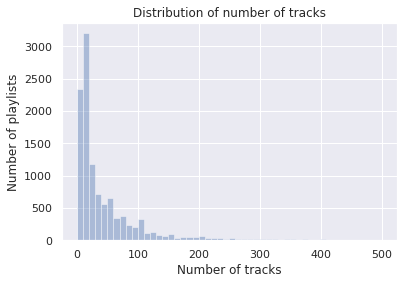

In [79]:
sns.distplot(playlists[total < 500].tracks.apply(lambda x: x['total']), kde=False)
plt.title("Distribution of number of tracks")
plt.xlabel("Number of tracks")
plt.ylabel("Number of playlists")
plt.show()

Most of playlists have few (100 or less) songs.

### How danceable, louder, ... are the songs?

Audio features dataset has a lot of variables, so we explore some of them.

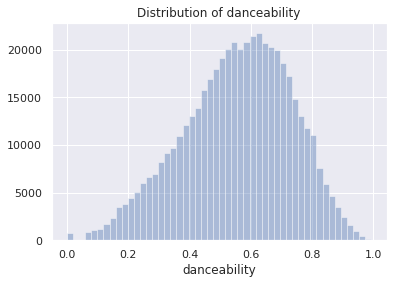

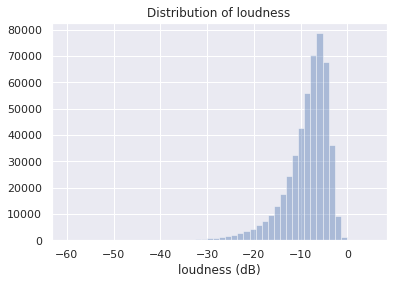

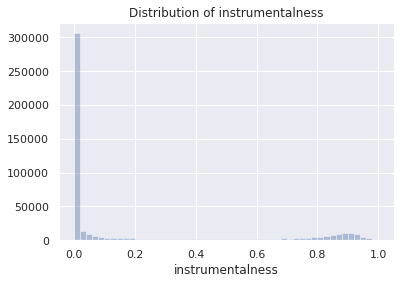

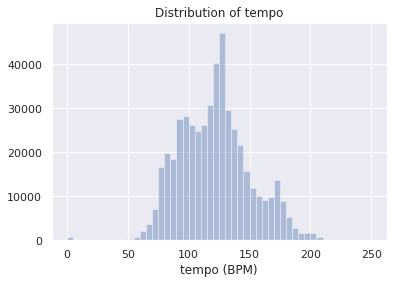

In [80]:
for variable in ['danceability', 'loudness', 'instrumentalness', 'tempo']:
    sns.distplot(audio_features[variable], kde=False)
    plt.title('Distribution of ' + variable)
    if variable == 'loudness':
        plt.xlabel('loudness (dB)')
    elif variable == 'tempo':
        plt.xlabel('tempo (BPM)')
    plt.show()

The features above describe a confidence or a metric made by Spotify. We see that `danceability` (how danceable a track is) has a very nice distribution, that is, most of songs are quite danceable. `Loudness` (in dB) concentrates itself around -10dB.

The distribution of `instrumentalness` is curious: there are tracks we may say they are instrumental (around 0.9), there are tracks we would it's not instrumental (close, but not, zero), and there are songs we are sure they are not instrumental (very close or equal to zero). Maybe it's because it's easy to say a song is not instrumental (it's easy to recognize voice), but the reverse is not so true. `temp` is another variable with a quite nice distributions. Songs vary it's tempo (in BPM) around 120.

One thing to say is that these graphs are quite compatible with those from [Spotify's Web API](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). It suggests that we are in the right way with our data.

### How popular are the artists?

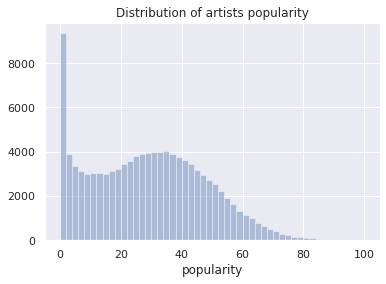

In [81]:
sns.distplot(artists.popularity, kde=False)
plt.title('Distribution of artists popularity')
plt.show()

This distribution is very close to the distribution of the popularity of the songs, curiously.

### What are the genres with more artists?

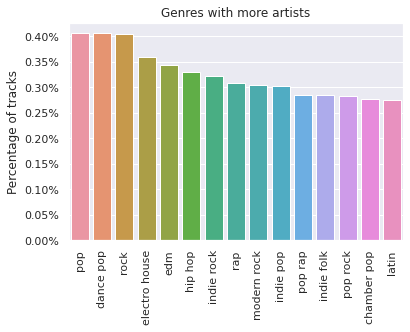

In [84]:
genres = []
for item in artists.genres.to_list():
    if type(item) == list:
        for genre in item:
            genres.append(genre)

counter = Counter(genres)

ax = sns.barplot(
    list(list(zip(*counter.most_common()))[0][:15]),
    [i/len(genres) for i in list(zip(*counter.most_common()))[1]][:15]
)
plt.xticks(rotation=90)
plt.title("Genres with more artists")
plt.ylabel("Percentage of tracks")

# https://stackoverflow.com/a/31357733
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.show()

These are the 10 genres with more artists. It seems very reasnable to have pop, rock, hip hop, rap and pop rock in this list. The percentages seems to be small, but it's because we have a lot of genres. That is:

In [ ]:
len(set(genres))

### Finnaly, what are the genres with more tracks?

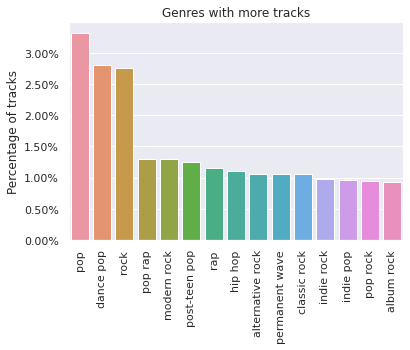

In [85]:
# We will only sample data because the datasets are big
# This cell takes a while to run
data = pd.concat(
    [pd.read_pickle(file)['artists_ids'].sample(1000) for file in glob.glob('../data/sp_tracks_ready_*.pkl')],
    ignore_index=True
)

artist_ids = []
for item in data.to_list():
    if type(item) == list:
        for artist_id in item:
            artist_ids.append(artist_id)

genres = []
for id in artist_ids:
    q = artists[artists.id == id].genres.iloc[0]
    if type(q) == list:
        genres.extend(q)

counter = Counter(genres)

ax = sns.barplot(
    list(list(zip(*counter.most_common()))[0][:15]),
    [i/len(genres) for i in list(zip(*counter.most_common()))[1]][:15]
)
plt.xticks(rotation=90)
plt.title("Genres with more tracks")
plt.ylabel("Percentage of tracks")

# https://stackoverflow.com/a/31357733
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.show()

Again, that's pretty reasonable. Pop and rock was expected to be in this list, so as rap and hip hop. Again, maybe the percentages seem small, but we have a lot of them:

In [87]:
len(set(genres))

2334

Many of the genres as sub-sub-subgenres, as you can see:

In [93]:
[genres[np.random.randint(len(genres))] for _ in range(15)]

['east coast hip hop',
 'detroit hip hop',
 'experimental pop',
 'alternative metal',
 'hip pop',
 'australian pop',
 'jungle',
 'mellow gold',
 'canadian pop',
 'big beat',
 'indie poptimism',
 'latin',
 'bebop',
 'post-teen pop',
 'irish rock']

### Are there correlations between numerical variables?

Let's analyse correlation in audio features dataset.

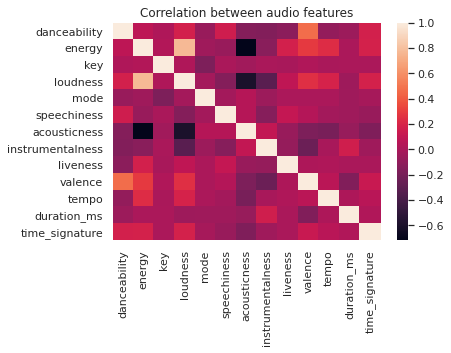

In [107]:
sns.heatmap(audio_features.corr())
plt.title("Correlation between audio features")
plt.show()

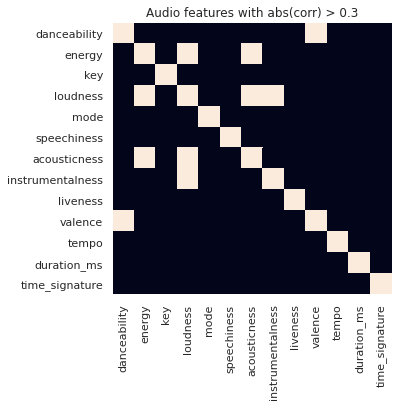

In [117]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(audio_features.corr().abs() > 0.3, cbar=False, ax=ax)
plt.title("Audio features with abs(corr) > 0.3")
plt.show()

We see strong correlations between
- `acousticness` and `energy`: they have strong negative correlation, because acoustic tracks in general are more calm;
- `acousticness` and `loudness`: the same as the latter;
- `energy` and `loudness`: the more energy the song, the louder it is;
- `valence` and `danceability`: the more valence (positiveness), the more danceable it is.
- `instrumental` and `loudness`: we found that a instrumental song tends to be less louder.